In [31]:
# all possibly useful imports:

import numpy as np
import matplotlib.pyplot as plt  
import sys  
import pandas as pd
import seaborn as sns 
import math
import statistics

from iminuit import Minuit
from scipy import stats
from scipy.stats import binom, poisson, norm    

from IPython.core.display import Latex
from sympy import * 



sys.path.append('../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax   
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH

#%load_ext autoreload
#%autoreload 2
#from ExamFunctions import make_chi2, weighted_mean




# Load data

In [ ]:
# load into numpy array:
F_data = np.loadtxt("data_FisherSyndrome.txt") 
print("Number of entries: ", len(F_data))

# pandas dataframe:
Fisher_df = pd.DataFrame(data=F_data, columns=["Ill", "Index", "A", "B", "C"]) 

# Functions

In [ ]:
# uncertainty on the mean:
sigma_mu = np.std(data) / np.sqrt(len(data))


# Uncertainty on uncertainty (standard deviation): 
sigma_sigma = 1/ np.sqrt(2*N-2)



## Weighted mean

In [2]:
def weighted_mean(x, x_err):
    """
    calculates weighted mean and its chi2 values
    returns weighted mean (muhat) and uncertainty (sigmahat)
    
    Use like this: muhat, sigmahat = weighted_mean(x, xerr)
    """
    
    err2 = np.power(x_err,2)
    err2[np.where(err2 == 0)] = 1e-50
    
    muhat = np.sum(x/err2) / np.sum(1/err2)
    sigmahat = np.sqrt(1/np.sum(1/err2))
      
    # calculate chi2
    chi2 = np.sum(((x - muhat) / x_err)**2)
    ndof = len(x) - 1
    p_val = stats.chi2.sf(chi2, ndof)
    
    # print mean, uncertainty, Chi2/Ndof and p-value
    print(f"    Weighted mean: {muhat:.4f} +- {sigmahat:.5f}    ({len(x)} measurements) ")
    print(f"    p(𝜒2={chi2:.2f}, Ndof={ndof}) = {p_val:.6f}")
    print(f"    𝜒2/Ndof  = {chi2 / ndof:.4f}")
    
    return muhat, sigmahat




## Likelihood of outliers (Gaussian distribution)

In [259]:
# Quantify likelihood of outliers:

def test_outliers(xdata, sigma_x, mu):
    '''Qunatifies the likelihood for every measurement 
    based on their distance to the mean in units of their respective uncertainty
    ! Assumes Gaussian distribution !'''
    
    for i in range(len(xdata)):
        x = xdata[i]
        sig_x = sigma_x[i]      # pretty sure this is correct...
        #sigmahat      # which sigma to use?? uncertainty on ind. measurement or on mean???

        dist = abs(x - mu)
        z = abs((x-mu)/sig_x)
        p = stats.norm.sf(abs(z))*2      # two-sided test
        
        # possibly take trial factor into account (if large sample):
        p_glob = 1 - (1 - p)**(len(xdata))
        
        
        if (p < 0.05):
            conc = 'Rejected'
        else: conc = 'Accepted'

        if (i==0):
            print(f'Meas. No.  -   Residuals (unit) -   No. sigma   -    Probability   -   Conclusion  - global prop ')

        print(f'     {i+1}     -       {dist:.2f}         -     {z:.2f}      -    {p:.8f}    -   {conc}    -  {p_glob:.4f}')


# Example data:      
g = [9.54, 9.36, 10.02, 9.87, 9.98, 9.86, 9.86, 9.81, 9.79]
sigma_g = [0.15, 0.10, 0.11, 0.08, 0.14, 0.06, 0.03, 0.13, 0.04]
muhat, sigmahat = 9.82, 0.02 

test_outliers(g, sigma_g, muhat)

Meas. No.  -   Residuals (unit) -   No. sigma   -    Probability   -   Conclusion  - global prop 
     1     -       0.28         -     1.87      -    0.06194815    -   Accepted    -  0.4376
     2     -       0.46         -     4.60      -    0.00000422    -   Rejected    -  0.0000
     3     -       0.20         -     1.82      -    0.06903635    -   Accepted    -  0.4747
     4     -       0.05         -     0.62      -    0.53197106    -   Accepted    -  0.9989
     5     -       0.16         -     1.14      -    0.25309791    -   Accepted    -  0.9277
     6     -       0.04         -     0.67      -    0.50498508    -   Accepted    -  0.9982
     7     -       0.04         -     1.33      -    0.18242244    -   Accepted    -  0.8368
     8     -       0.01         -     0.08      -    0.93868474    -   Accepted    -  1.0000
     9     -       0.03         -     0.75      -    0.45325470    -   Accepted    -  0.9956


## Trial factor

In [260]:
# Calculate global significance taking trial factor = N into account:
n = 20
p_loc = p_val

p_glob = 1 - (1 - p_loc)**n
print(f' p global = {p_glob:.4f} (with trial factor {n} and p local {p_loc:.2e}) ')

 p global = 0.0001 (with trial factor 20 and p local 3.17e-06) 


# I Distributions and Probabilities

In [ ]:
def test_dist(n,p):
    '''Based on n and p, tests if it can be a Poisson or a Gaussian distribution.'''
    if (n > 50) & (p < 0.1):    
        print(f" POISSON: n = {n}, p = {p} => Poisson approximation holds (n=50, p=0.1).")
    else:
        print(f" n = {n}, p = {p} => Poisson approximation does NOT hold (n=50, p=0.1).")
    if ((n*p)>20):
        print(f" GAUSSIAN: lambda = {n*p} => Gaussian approximation holds (lambda > 20).")
    else:
        print(f" lambda = n*p = {n*p} => Gaussian approximation does NOT hold (lambda > 20).")
        


## Binomial probability
Points are given for:
* correctly calculated probabilities
* mentioning Poisson distribution

Points are taken away for:
* wrong interpretation of results
* misinterpretation of the question

A game is worth playing if probability > 50%

In [233]:
def binomial_prob(possible_outcomes, p, n):
    '''
    Calculates Probability of getting x or more successes in n trials
    following binomial probability function: sum of p(x) + p(x+1) + .... + p(x+...),
    where P(X=r) = nCr * pʳ * (1-p)ⁿ⁻ʳ
    '''
    overall_prob = 0

    for outcome in possible_outcomes:
        
        r = outcome
        combinations = np.math.factorial(n)/ (np.math.factorial(r) * np.math.factorial(n-r))
        prob = combinations * p**r * (1-p)**(n-r)
        #print(f" Probability for {outcome} successes = {prob}")
        overall_prob += prob

    #print(f"RESULT: Probability for {possible_outcomes[0]} - {possible_outcomes[-1]} successes in {n} tries = {overall_prob:f}")
    return overall_prob

# use like this:
p = 1/6
n = 4
poss_outcomes = [1,2,3,4]
prob = binomial_prob(poss_outcomes, p, n)
print(f"RESULT: Probability for {poss_outcomes[0]} - {poss_outcomes[-1]} successes in {n} tries = {prob:f}")
    


# -------------------------------
# Brad Pitt and Edward Norton are shooting golf balls at a window with p_hit = 0.054 chance of hitting. 
# How many golf balls do they need to be 90% sure of hitting the window?

p = 0.054
for n in np.arange(2,100):
    poss_outcomes = np.arange(1,n+1)
    prob = binomial_prob(poss_outcomes, p, n)
    if (prob>0.9):
        print(n)
        print(f"RESULT: Probability for {poss_outcomes[0]} - {poss_outcomes[-1]} successes in {n} tries = {prob:f}")
        break
        

# -------------------------------
# Simulate probabilities:

# Probability for 1 - 4 successes in 4 tries:

n = 4
p = 1/6
nexp = 100000

successes = np.zeros(nexp)

r = np.random
#r.seed(42)

for i in range(nexp):
    dice_rolls = r.randint(low=1, high=6+1, size=n, dtype=int)
    successes[i] = np.sum(dice_rolls==6)


sim_prob = np.sum(successes > 0) / len(successes)
print(f"SIMULATED RESULT: Probability for 1 - {n} successes in {n} tries = {sim_prob:f}   ({nexp} simulations)")

    
        
    

RESULT: Probability for 1 - 4 successes in 4 tries = 0.517747
42
RESULT: Probability for 1 - 42 successes in 42 tries = 0.902853
SIMULATED RESULT: Probability for 1 - 4 successes in 4 tries = 0.518600   (100000 simulations)


## Poisson probability

In [238]:
def my_poisson(my_k, my_lamb):   # k = number of occurences
    return my_lamb**my_k / np.math.factorial(my_k) * np.exp(-my_lamb)

from scipy.stats import poisson


# Poisson probability for one value of k (= occurences):
k = 42
lamb = 18.9  #n*p
n = 1730
mu = lamb

prob_k = my_poisson(k, lamb)             # version 1
prob_k2 = poisson.pmf(k, mu, loc=0)      # version 2, gives same result

print(f' probability (X = k = {k}) = {prob_k:.2e}, {prob_k2:.2e}')


# Poisson significance of a value (= integral of that value and beyond, like Gaussian p-val):

# version 1:   (CORRECT)
k_list = np.arange(0,42)                
neg_p_val = 0
for ks in k_list:  
    neg_p_val += my_poisson(ks, lamb)
p_val = 1 - neg_p_val
print(f' The probability of {k_list[-1]} or more (extreme) events is: {p_val:.2e} (local significance)')


# version 2 & 3: ----------------- give WRONG results!! bc they take the integral, not the sum! ---
p_val2 = 1 - poisson.cdf(k=42, mu=18.9, loc=0)
p_val3 = poisson.sf(k, mu, loc=0)         # sf = survival function, defined as 1 - cdf   => more accurate
#print(f' p local = {p_val:.2e}, {p_val3:.2e}')
#print('  NOT THE SAME - OURS IS CORRECT!')

#print(f' The probability of {k_list[-1]} or more (extreme) events is: $\sum_{i={{k_list[-1]}}}^{i=\infty}$')

#p(42 + events) = ∑ Pois(i, λ) = 0.00000317)


# ------------------------------------------------
# Calculate global significance taking trial factor = N into account:

p_loc = p_val
p_glob = 1 - (1 - p_loc)**n
print(f' p global = {p_glob:.4f} (with trial factor {n} and p local {p_loc:.2e}) ')



 probability (X = k = 42) = 1.80e-06, 1.80e-06
 The probability of 41 or more (extreme) events is: 3.17e-06 (local significance)
 p global = 0.0055 (with trial factor 1730 and p local 3.17e-06) 


## Gaussian probability

In [ ]:
def z_test_onesample(x,mu,sig_x):
    '''
    One-sample z-Test (Gaussian assumption)
    Rule-of-thumb: If N > 10-20 or σ known then Z-test, else T-test.
    This is a two-tailed test!
    '''
    z = (x-mu)/sig_x
    #print(f" z-score = {z}")
    print(f" {x:.2f} is {z:.4f} sigma away from {mu:.2f}.")

    #find p-value for two-tailed test
    p_val = stats.norm.sf(abs(z))*2
    print(f" p-value = {p_val:.4f}")
    
    return p_val

    # Find prob from z-score:
    # left-tailed: scipy.stats.norm.sf(abs(-0.77))
    # right-tailed: scipy.stats.norm.sf(abs(1.87))
    # two-tailed: scipy.stats.norm.sf(abs(1.24))*2


def z_test_twosample(x1,x2,sig_x1, sig_x2):
    '''
    Two-sample z-Test (Gaussian assumption)
    Rule-of-thumb: If N > 10-20 or σ known then Z-test, else T-test.
    This is a two-tailed test!
    '''
    z = (x1-x2)/(np.sqrt(sig_x1**2 + sig_x2**2))
    #print(f" z-score = {z}")
    print(f" {x:.2f} is {z:.4f} sigma away from {mu:.2f}.")

    #find p-value for two-tailed test
    p_val = stats.norm.sf(abs(z))*2
    print(f" p-value = {p_val:.4f}")
    
    return p_val    

# II - Error propagation

In [157]:
a = 5
b = 3

y = 2 * a * b

sigma_a = 0.1
sigma_b = 0.5

derivative_a = a**2/b
derivative_b = 2*b

sigma_y = np.sqrt(derivative_a**2 * sigma_a**2 + derivative_b**2 * sigma_b**2)

print(f'y = ({y:.2f} ± {sigma_y:.2f}) unit')

y = (30.00 ± 3.11) unit


## Simulating uncertainties

  Mean ± Std = 0.521 ± 0.016


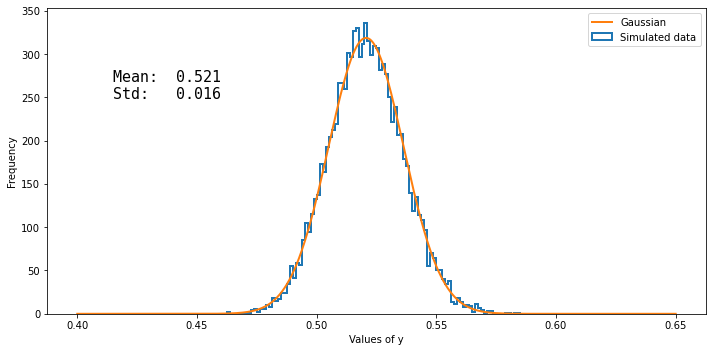

In [264]:
# Simulate uncertainties:

N_exp = 10000                       # Number of "experiments" (i.e. drawing from random distributions)
mu_a, sig_a   =   0.96, 0.03    #3.1, 0.98          # enter values here
mu_b, sig_b   =  8.4, 0.5

r = np.random
r.seed(42)
a_sim = r.normal(mu_a, sig_a, N_exp)
b_sim = r.normal(mu_b, sig_b, N_exp)

y_all = (1 + a_sim**2)**(-1)  # 1/2 * a_sim * b_sim**2     # enter correct formula here!
#y_all = (1 - a_sim)**(-2)  # 1/2 * a_sim * b_sim**2         # enter correct formula here!

mean, std = y_all.mean(), y_all.std(ddof=1)
print(f"  Mean ± Std = {mean:5.3f} ± {std:5.3f}")     # gives same result as error prop formula, if Gaussian


# Plot result
# -------------------------------------------------------------
nbins = 200                        # set how I want it
xmin, xmax = 0.4,0.65                   # set how I want it
binwidth = (xmax-xmin)/nbins

fig2, ax2 = plt.subplots(figsize=(10, 5));
counts, bin_edges, _ = ax2.hist(y_all, nbins, range=(xmin, xmax), histtype='step', linewidth=2, label = 'Simulated data')
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)
ax2.set(xlabel='Values of y', ylabel='Frequency')

# evaluate if it is a Gaussian distribution:
def gaussian(x, N, mu, sigma):
    return N * binwidth / (sigma*np.sqrt(2*np.pi)) * np.exp(-0.5* (x-mu)**2/sigma**2)

xaxis = np.linspace(xmin, xmax, 1000)
yaxis = gaussian(xaxis, N_exp, mean, std)
ax2.plot(xaxis, yaxis, linewidth=2, label = 'Gaussian')
ax2.legend()

d = {'Mean:': mean, 'Std:': std}
text = nice_string_output(d, extra_spacing=2, decimals=3)   # select how many decimals
add_text_to_ax(0.1, 0.8, text, ax2, fontsize=15);

#fig2.savefig('sim_uncertainties.jpg', dpi=600)



# III - Monte Carlo

## Transformation method

Nbins = 100 close to sqrt(n) = 100?


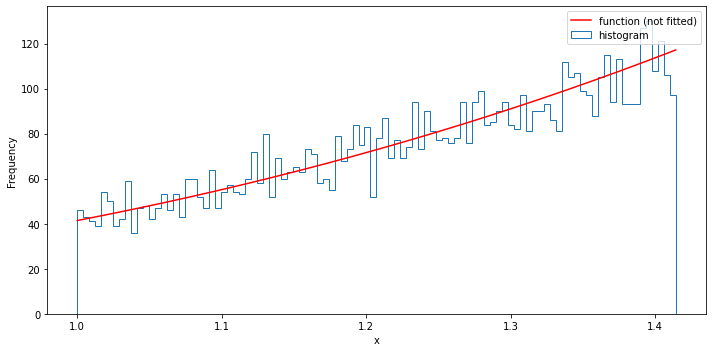

In [159]:
# TRANSFORMATION METHOD:

# Define functions and variables: -----------------------------
def my_func(x) :
    k = (xmax - xmin) / N_bins
    N = N_points * k             # Normalization is N_points * binwidth:
    return N * x**3              # = anti-normalizing the function

def Fminusr(y):                  # F^-1(r): inverse of the integral   
    return (4*y)**(1/4) 
  
xmin, xmax = 1, 4**(1/4)      # x range 
N_points = 10000              # Number of random points produced
N_bins = 100                  # how many bins? rule of thumb: sqrt of n
print(f"Nbins = {Nbins} close to sqrt(n) = {np.sqrt(N_points):.0f}?")    

C = 1    # possibly needed normalization parameter


# -----------------------------------------------------------
# produce random points
r = np.random
r.seed(42)
x_transformation = Fminusr(r.uniform(size=N_points))   

# Plot histogram and function on top:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(x_transformation, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
ax.set(xlabel="x", ylabel="Frequency") #, xlim=(xmin-0.1, xmax+0.1));

x_axis1 = np.linspace(xmin, xmax, 1000)
y_axis1 = my_func(x_axis1)
ax.plot(x_axis1, y_axis1, 'r-', label='function (not fitted)')

d = {'Entries': len(x_transformation), 'Mean': x_transformation.mean(), 'Std': x_transformation.std(ddof=1)}
text = nice_string_output(d, extra_spacing=2, decimals=3)
#add_text_to_ax(0.05, 0.75, text, ax, fontsize=14)

ax.legend(loc='best')
fig.tight_layout()

# fig.savefig("TransformationMethod.pdf", dpi=600)



## Accept-reject method

Integral of f(x) = C*x**(-0.9), x in [0.005, 1] is: 	  0.9939 +- 0.0098
The efficiency of the accept/reject method is:  	 3.49% +/- 0.03%


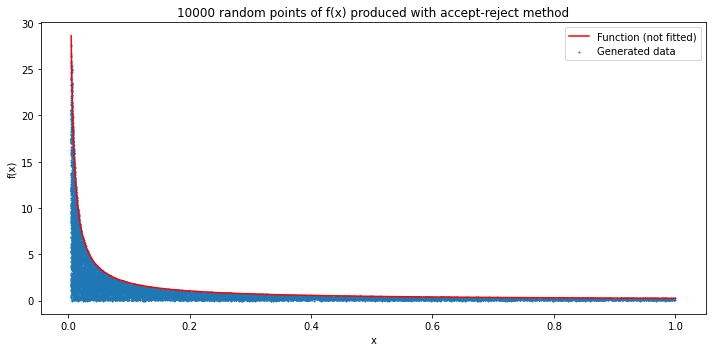

In [160]:
# ACCEPT-REJECT METHOD:

# Define function and parameters: ------------------------------
def my_func(x):
    return C * x**(-0.9)    # no need to normalize, as it is a PDF...

xmin, xmax = 0.005, 1       # set x-range
C = 0.243134                # define parameters
ymax = my_func(xmin)
N_points = 10000            # how many random points to produce?
#Nbins = 100                 # how many bins (for normalization)? rule of thumb: sqrt of n
#print(f"Nbins = {Nbins} close to sqrt(n) = {np.sqrt(N_points):.0f}?")


# SIMULATE -----------------------------------------------------------
x_sim = np.zeros(N_points)
y_sim = np.zeros(N_points)
Ntry = 0
r = np.random
r.seed(42)

for i in range(N_points):
    while True:
        Ntry += 1
        x2 = r.uniform(xmin, xmax)  
        y2 = r.uniform(0,    ymax)        
        if (y2 < my_func(x2)) :       # If the (x,y)-point fulfills the accept condition...
            break
            
    x_sim[i] = x2                     # ...then break and accept the x-value
    y_sim[i] = y2  
    
# -----------------------------------------------------------
eff = N_points / Ntry                        # Efficiency of generating points (fraction accepted)
eff_error = np.sqrt(eff * (1-eff) / Ntry)    # Error on efficiency (binomial)
integral =  eff * (xmax-xmin) * ymax               # Integral
integral_error = eff_error * (xmax-xmin) * ymax    # Error on integral
print(f"Integral of f(x) = C*x**(-0.9), x in [0.005, 1] is: \t {integral:7.4f} +- {integral_error:6.4f}")
print(f"The efficiency of the accept/reject method is:  \t {eff:.2%} +/- {eff_error:.2%}")
# Since the integral of x*cos in [0,pi/2] is around 0.57, the proper normalisation is 1/0.57
# -----------------------------------------------------------

fig3, ax3 = plt.subplots(figsize=(10, 5))
ax3.scatter(x_sim, y_sim, s=1, label='Generated data')  # s defines point size 
ax3.set(xlabel="x", ylabel="f(x)", title=f'{N_points} random points of f(x) produced with accept-reject method') #, xlim=(0, 10), ylim=(0, 0.4))
# optional: specify x range in label: x ∈ [0.005,1]

# Plot f(x)
x_axis = np.linspace(xmin, xmax, 1000)
y_axis = my_func(x_axis)
ax3.plot(x_axis, y_axis,'r-', label='Function (not fitted)') 

# Make figure text
d3 = {'Entries': len(x_sim), 'Mean x': x_sim.mean(), 'Mean y ': y_sim.mean(), 'Std x': x_sim.std(ddof=1),'Std y': y_sim.std(ddof=1)}
      #'Median x': np.median(x_sim), 'Median y': np.median(y_sim),
text3 = nice_string_output(d3, extra_spacing=2, decimals=3)
#add_text_to_ax(0.6, 0.7, text3, ax3, fontsize=15)

ax3.legend(loc='best')
fig3.tight_layout()

#fig3.savefig("accept_reject.pdf", dpi=600)


## Combination: accept-reject bound with a function

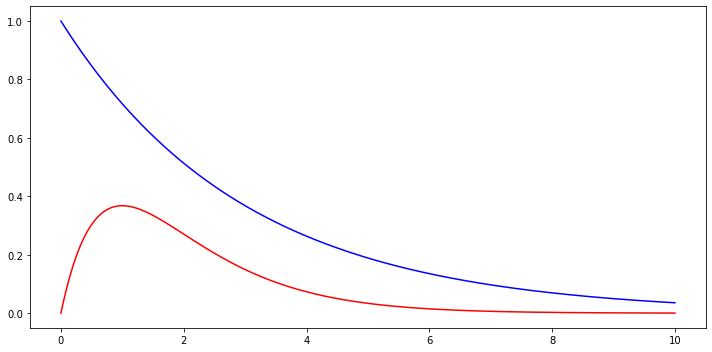

In [183]:
# COMBINATION: ACCEPT-REJECT bound with a function


#1. plot function and find a function that is always larger:

def fx(x) :
    return x * np.exp(-x) 
    # potentially need to normalize with C   (or with N_points * binwidth ?)   (binwidth = (xmax - xmin) / N_bins) 

def gx(x) :
    return np.exp(-x/3)

xmin, xmax = 0, 10
N_bins = 100
N_points = 1000

fig, ax = plt.subplots(figsize=(10, 5))
x_axis1 = np.linspace(xmin, xmax, N_points)
y_axis1 = fx_norm(x_axis1)
y_axis2 = gx(x_axis1)

ax.plot(x_axis1, y_axis1, 'r-', label='f(x)')
ax.plot(x_axis1, y_axis2, 'b-', label='g(x)')


Integral of f(x) = ..., x in [0,inf] is:  	  0.9930 +- 0.0257
The efficiency of the accept/reject method used here is: 	 33.10% +/- 0.86%


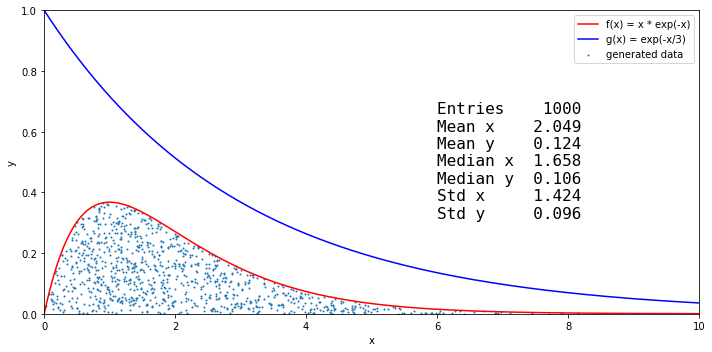

In [184]:
# Produce points following g(x) using the transformation method:

# define function and parameters:


def fx(x) :
    return x * np.exp(-x) 

def gx(x) :
    return np.exp(-x/3)

def gx_inv(x):                 # inverse of g(x)
    return -3.0 * np.log(x)

N_points = 1000 
xmin, xmax = 0, 10

# -----------------------------

x_sim = np.zeros(N_points)       # these are the relevant values of f(x)!! => can be used for histogram
y_sim = np.zeros(N_points)       # We also save the y-values simply to make an illustrative scatter plot!
Ntry = 0

r.seed(42)
for i in range(N_points):
    while True:
        Ntry += 1
        x3 = gx_inv(r.uniform(low=0.0, high=1.0))   # producing x-values following transformation method 
        y3 = r.uniform(0.0, gx(x3))                 # producing y-values in range 0 - g(x)
        if (y3 < fx(x3)) :                  # accept if compatible with f(x)
            break
            
    x_sim[i] = x3                           
    y_sim[i] = y3
    
# --------------------------
f  = N_points / Ntry
ef = np.sqrt(f * (1.0-f) / Ntry)

integral3  = 3.0 * f       # Multiply integral of exponential (k(x)) with fraction
eintegral3 = 3.0 * ef      # Same for error

print(f"Integral of f(x) = ..., x in [0,inf] is:  \t {integral3:7.4f} +- {eintegral3:6.4f}")
print(f"The efficiency of the accept/reject method used here is: \t {f:.2%} +/- {ef:.2%}")
# ----------------------------------


# Distribution of (x,y) points (for illustration) with h(x) and k(x) on top:
fig3, ax3 = plt.subplots(figsize=(10, 5))
ax3.scatter(x_sim, y_sim, s=1, label='generated data')
ax3.set(xlim=(0, 10), ylim=(0, 1), xlabel='x', ylabel='y')


# Plot f(x)
x_axis3 = np.linspace(0, 10, 1000)
y_axis3 = fx(x_axis3)
ax3.plot(x_axis3, y_axis3,'r-', label='f(x) = x * exp(-x)')  # insert correct function here

# Plot g(x)
x_axis4 = np.linspace(0, 10, 1000)
y_axis4 = gx(x_axis4)
ax3.plot(x_axis4, y_axis4,'b-', label='g(x) = exp(-x/3)')    # insert correct function here

# Make figure text
d3 = {'Entries': len(x_sim),
      'Mean x': x_sim.mean(),
      'Mean y': y_sim.mean(),
      'Median x': np.median(x_sim),
      'Median y': np.median(y_sim),
      'Std x': x_sim.std(ddof=1),
      'Std y': y_sim.std(ddof=1),
     }

text3 = nice_string_output(d3, extra_spacing=2, decimals=3)
add_text_to_ax(0.6, 0.7, text3, ax3, fontsize=16)

ax3.legend(loc='best')
fig3.tight_layout()


#fig3.savefig("ScatterAnd2Func.pdf", dpi=600)

# IV - Statistical tests

In [ ]:
def make_chi2(y_data, y_fit, sigma_y, ndof):
    """
    Calculates the chi2 value between two arrays: data and fit.
    Returns Chi2, p-value and ndof and prints them in a nice format.
    Gaussian assumption!
    
    Use like this: chi2, pval, ndof = make_chi2(y_data, y_fit, sigma_y, ndof)
    """
    
    chi2 = 0
    for i in range(len(y_data)):
        chi2 += (y_data[i] - y_fit[i])**2/sigma_y**2
        
    # chi2_np = np.sum((y_data-y_fit)**2 / sigma_y**2)   # numpy optimized way

    p_val = stats.chi2.sf(chi2, ndof)
    
    # Report result:
    print(f"p(𝜒2={chi2:.2f}, Ndof={ndof}) = {p_val:.6f}")
    print(f"𝜒2/Ndof  = {chi2 / ndof:.4f}")
    
    return chi2, p_val, ndof



In [ ]:
def z_test_onesample(x,mu,sig_x):
    '''
    One-sample z-Test (Gaussian assumption)
    Rule-of-thumb: If N > 10-20 or σ known then Z-test, else T-test.
    This is a two-tailed test!
    '''
    z = (x-mu)/sig_x
    #print(f" z-score = {z}")
    print(f" {x:.2f} is {z:.4f} sigma away from {mu:.2f}.")

    #find p-value for two-tailed test
    p_val = stats.norm.sf(abs(z))*2
    print(f" p-value = {p_val:.4f}")
    
    return p_val

    # Find prob from z-score:
    # left-tailed: scipy.stats.norm.sf(abs(-0.77))
    # right-tailed: scipy.stats.norm.sf(abs(1.87))
    # two-tailed: scipy.stats.norm.sf(abs(1.24))*2


def z_test_twosample(x1,x2,sig_x1, sig_x2):
    '''
    Two-sample z-Test (Gaussian assumption)
    Rule-of-thumb: If N > 10-20 or σ known then Z-test, else T-test.
    This is a two-tailed test!
    '''
    z = (x1-x2)/(np.sqrt(sig_x1**2 + sig_x2**2))
    #print(f" z-score = {z}")
    print(f" {x:.2f} is {z:.4f} sigma away from {mu:.2f}.")

    #find p-value for two-tailed test
    p_val = stats.norm.sf(abs(z))*2
    print(f" p-value = {p_val:.4f}")
    
    return p_val    



In [ ]:
# t-Test?

In [ ]:
# Chi2 of a histogram + fit:

# needed input:
hist1 = ax.hist(x_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='red', label='Gaussian ($\mu$ = -0.5)')
# Fit parameters, here: fit_N, fit_mu, fit_sigma


# prepare caclulation:
entries, bin_edges, _ = hist1
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

hist1_x = bin_centers 
hist1_y = entries
hist1_sy = np.sqrt(hist1_y)

 
# calculate the chi2 value of the fit and the number of non-empty bins in a for-loop:
chi2_val = 0
N_NotEmptyBin = 0

for x, y, sy in zip(hist1_x, hist1_y, hist1_sy):
    if y > 0:
        f = binwidth * gauss_extended(x, fit_N, fit_mu, fit_sigma)   # Calc the model value
        chi2_val  += (y - f)**2 / sy**2                              # Calulate the chi2 value
        N_NotEmptyBin += 1             # Count the bin as non-empty since y>0 (and thus sy>0)
               
        
# Optimal way of utilizing Numpy's true power by vectorizing the code:
f = binwidth * gauss_extended(hist1_x, fit_N, fit_mu, fit_sigma)
mask_zeroes = (hist1_y > 0)

chi2_val_np = np.sum( (f[mask_zeroes] - hist1_y[mask_zeroes])**2 / hist1_sy[mask_zeroes]**2)
N_NotEmptyBin_np = np.sum(mask_zeroes)


# Calculate Chi2 probability:
N_DOF = N_NotEmptyBin - len(minuit.values[:])
chi2_prob = stats.chi2.sf(chi2_val, N_DOF) # The chi2 probability given N_DOF degrees of freedom
chi2_prob

'''This shows us that there is a 80% probability of obtaining a worse fit just by chance. 
 Or, to quote Wikipedia: 
 The p-value is the probability of observing a test statistic at least as extreme in a chi-squared distribution. '''





In [125]:
# KS-test:

# Test if there is a difference with the Kolmogorov-Smirnov test on arrays (i.e. unbinned):
# -----------------------------------------------------------------------------------------
p_ks = stats.ks_2samp(x_A_array, x_B_array)[1]           # Fortunately, the K-S test is implemented in stats!



1.4142135623730951

In [ ]:
# Fisher's exact test:
'''calculates the probability of the entries in a contingency table to be uncorrelated. 
    Thus, the Null-Hypothesis is that the entries are uncorrelated, 
    while the alternative hypothesis represents the case where the entries are correlated
'''


# Contingency table:
#              Vaccine :        Control :           Sum:
# Positive:    A = cov_vacc    B = cov_plac
# Negative:    C =  neg_vacc   D = neg_plac
# Sum:        A+C = N_vacc     B+D = N_plac

A = cov_vacc
B = cov_plac
C = N_vacc - cov_vacc
D = N_plac - cov_plac
N = N_vacc + N_plac


p = (math.comb(A+C, A)*math.comb(B+D,B))/math.comb(N,A+B)
print(p)

# => small prob = the entries are correlated => the vaccine is effective!

In [ ]:
# Chi2 / Likelihood ratio test - compares two hypotheses:
# --------------------------------------------------------------
Chi2_1, Ndof_1 =167, 31    # full model    (more Ndof)
Chi2_2, Ndof_2 =35, 28     # reduced model (less Ndof)

new_Chi2 = Chi2_1 - Chi2_2
new_Ndof = Ndof_1 - Ndof_2

new_ProbChi2 = stats.chi2.sf(new_Chi2, new_Ndof)
print(f"p(Chi2={new_Chi2:.0f}, Ndof={new_Ndof}) = {new_ProbChi2:.2e}")

# p(Chi2=132, Ndof=3) = 2.00e-28 
# => the probability that the two models are the same is very small, meaning that they are different (and the 2nd model is significantly better)





In [ ]:
# Difference in the mean:
def mean_std_sdom(x):
    std = np.std(x, ddof=1)
    return np.mean(x), std, std / np.sqrt(len(x))


# Test if there is a difference in the mean:
# ------------------------------------------
# Calculate mean and error on mean:
mean_A, width_A, sdom_A = mean_std_sdom(x_A_array) 
mean_B, width_B, sdom_B = mean_std_sdom(x_B_array) 

# Consider the difference between means in terms of the uncertainty:
d_mean = mean_A - mean_B
z_mean = d_mean/np.sqrt(sdom_A**2+sdom_B**2)

# Turn a number of sigmas into a probability (i.e. p-value):
p_mean = 1.0 - stats.norm.cdf(z_mean,loc=0,scale=1)  # To get a p-value, we ask what the chance is to get a larger difference



# Fisher discriminant

In [ ]:
# Fisher discriminant 
def Fisher_disc(set_A, set_B):
    ''' 
    Calculates Fisher discriminant between two datasets.
    Input required: set_A and set_B, where columns = discriminating variables and rows = observations.
    Returns the two separated datasets along the discriminant 
    and the distance between these distributions as measure of goodness of separation.
    '''
    
    mu_A = np.mean(set_A, 0)
    mu_B = np.mean(set_B, 0)
    
    cov_A = np.cov(set_A, rowvar=False)        # covariance matrix
    cov_B = np.cov(set_B, rowvar=False)
    
    cov_sum = cov_A + cov_B
    cov_sum_inv = np.linalg.inv(cov_sum)
    
    wf = np.dot(cov_sum_inv, (mu_A - mu_B))   # Fisher weights
    
    fisher_data_A = np.dot(wf, set_A.T)      #  Fisher discriminant
    fisher_data_B = np.dot(wf, set_B.T)
    
    d = np.abs((np.mean(fisher_data_A) - np.mean(fisher_data_B))) / np.sqrt(np.std(fisher_data_A, ddof=1)**2 + np.std(fisher_data_B, ddof=1)**2)  
    print(f" Fisher separation (distance): {d:.4f}")
    
    return fisher_data_A, fisher_data_B, d

# ---------------------------------------------------------------

    
fisher_data_A, fisher_data_B, dist = Fisher_disc(AB_ill, AB_healthy)

# plot histogram
xmin, xmax = -30, 0
Nbins = 25
fig_fisher, ax_fisher = plt.subplots(figsize=(10, 5))
ax_fisher.hist(fisher_data_A, Nbins, (xmin, xmax), histtype='step', color='Red', label='Species A')
ax_fisher.hist(fisher_data_B, Nbins, (xmin, xmax), histtype='step', color='Blue', label='Species B')
ax_fisher.set(xlim=(xmin, xmax), xlabel='Fisher discriminant', title=f'Fisher discriminant \n$\Delta_{{fisher}} = {dist:.2f}$'))
ax_fisher.legend()
#ax_fisher.text(-7,500, fr'$\Delta_{{fisher}} = {dist:.3f}$', fontsize=16)
fig_fisher.tight_layout()

#fig_fisher.savefig('FisherOutput.pdf', dpi=600)



### ROC curve

In [ ]:
# ROC curves:
#!pip install scikit-learn
from sklearn.metrics import roc_curve, auc


# Required Input: a matrix where columns: 0 = labels, 1 - n = variables
data = np.array(Fisher_df.drop(columns=['Index']))

fisher_ABC = np.concatenate([fisher_data_A1, fisher_data_B1])
fisher_AB = np.concatenate([fisher_data_A2, fisher_data_B2])
fisher_BC = np.concatenate([fisher_data_A3, fisher_data_B3])
fisher_AC = np.concatenate([fisher_data_A4, fisher_data_B4])

# for the roc_curve func, positives > negatives. 
# If that is not the case along some dimensions (see hist), take -1*data[:,3]
fprA, tprA, tA = roc_curve(data[:,0], data[:,1])      
fprB, tprB, tB = roc_curve(data[:,0], -1*data[:,2])
fprC, tprC, tC = roc_curve(data[:,0], -1*data[:,3])

fprABC, tprABC, tABC = roc_curve(data[:,0], fisher_ABC)
fprAB, tprAB, tAB = roc_curve(data[:,0], fisher_AB)
fprBC, tprBC, tBC = roc_curve(data[:,0], fisher_BC)
fprAC, tprAC, tAC = roc_curve(data[:,0], fisher_AC)


# Plot ROC curves:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fprA, tprA, label=f'Separation based on A (AUC={auc(fprA,tprA):.4f})')
ax.plot(fprB, tprB, label=f'Separation based on B (AUC={auc(fprB,tprB):.4f})')
ax.plot(fprC, tprC, label=f'Separation based on C (AUC={auc(fprC,tprC):.4f})')

ax.plot(fprABC, tprABC, label=f'Separation based on ABC (Fisher) (AUC={auc(fprABC,tprABC):.4f})')
ax.plot(fprAB, tprAB, label=f'Separation based on AB (Fisher) (AUC={auc(fprAB,tprAB):.4f})')
ax.plot(fprBC, tprBC, label=f'Separation based on BC (Fisher) (AUC={auc(fprBC,tprBC):.4f})')
ax.plot(fprAC, tprAC, label=f'Separation based on AC (Fisher) (AUC={auc(fprAC,tprAC):.4f})')

ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label='Random classifier')
ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title='ROC curves')
ax.legend()

#fig.savefig('ROC_curves.pdf', dpi=600)


In [ ]:
# Make example code / functions for:


# example of how to use Latex in Jupyter




